**Vehicle Detection Project**

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

In [1]:
# Visualize & plot
def visualizeResult2(image, result, text_image, text_result, image_gray= False, result_gray= False):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)

    ax1.set_title(text_image, fontsize=20)
    ax2.set_title(text_result, fontsize=20)
 
    if image_gray == True:
        ax1.imshow(image, cmap='gray')
    else:
        ax1.imshow(image)
        
    if result_gray == True:
        ax2.imshow(result, cmap='gray')
    else:
        ax2.imshow(result)

### Helper functions for vehicle detection

In [2]:
import cv2
import numpy as np
from skimage.feature import hog


def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)


def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:, :, 0], size).ravel()
    color2 = cv2.resize(img[:, :, 1], size).ravel()
    color3 = cv2.resize(img[:, :, 2], size).ravel()
    return np.hstack((color1, color2, color3))


def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:, :, 0], bins=nbins)
    channel2_hist = np.histogram(img[:, :, 1], bins=nbins)
    channel3_hist = np.histogram(img[:, :, 2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


# Hog Feature and Visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True,
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True,
                       visualise=vis, feature_vector=feature_vec)
        return features


def extract_features(imgs, color_space='YCrCb', spatial_size=(32, 32), hist_bins=32, orient=9,
                     pix_per_cell=8, cell_per_block=2, hog_channel='ALL', spatial_feat=True, hist_feat=True,
                     hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)

        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(image)

        if spatial_feat is True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat is True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat is True:
            # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:, :, channel],
                                                         orient, pix_per_cell, cell_per_block,
                                                         vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:, :, hog_channel], orient,
                                                pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

C:\Users\joern\Anaconda3\envs\CarND\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


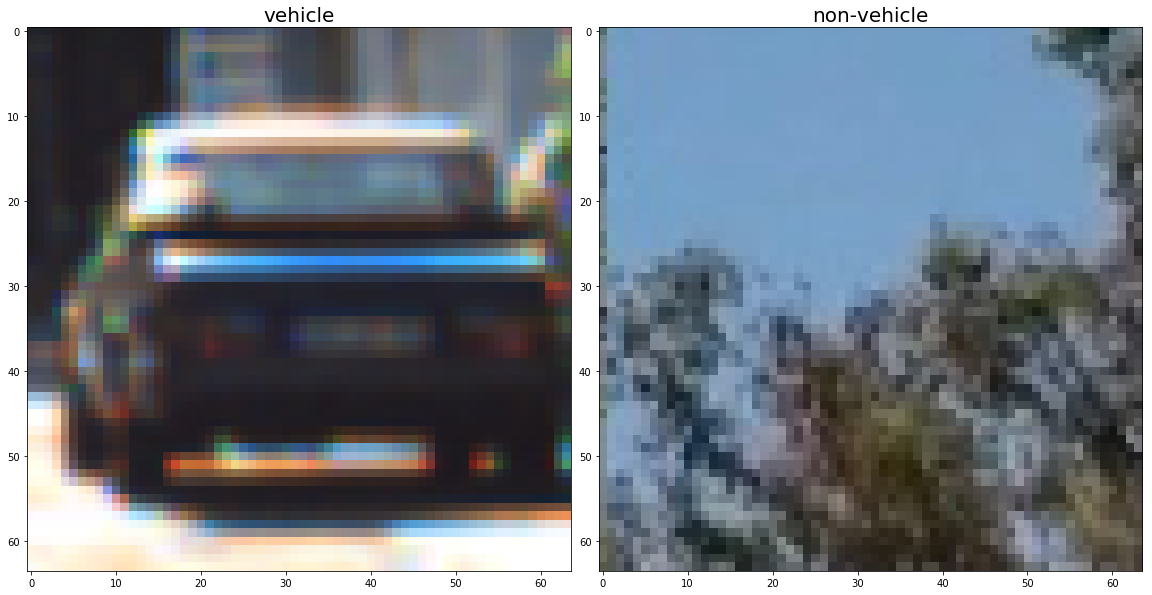

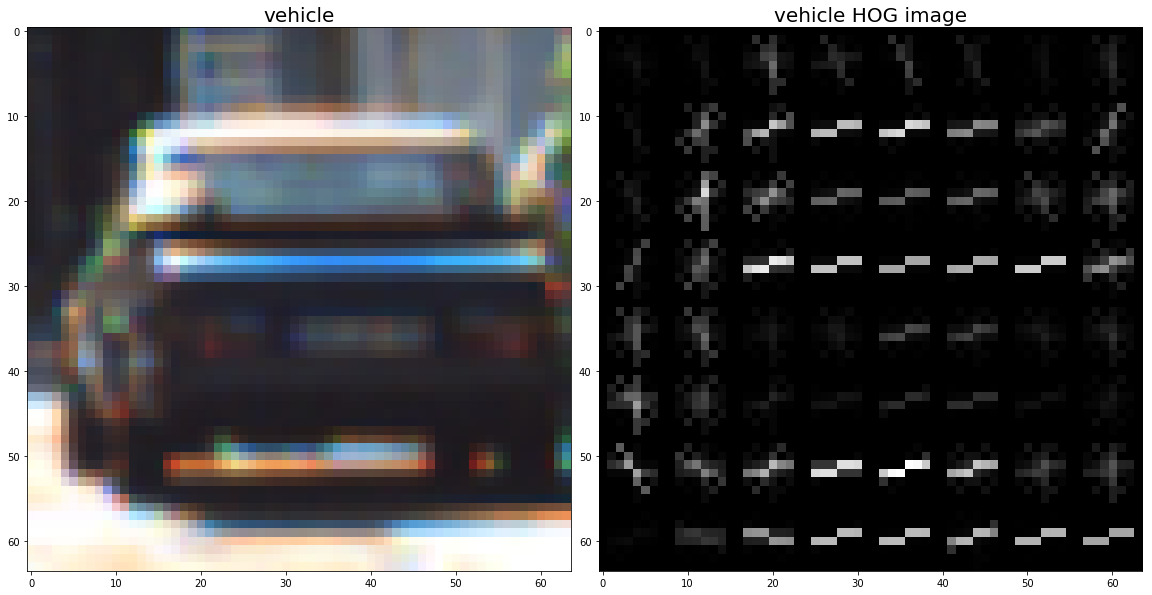

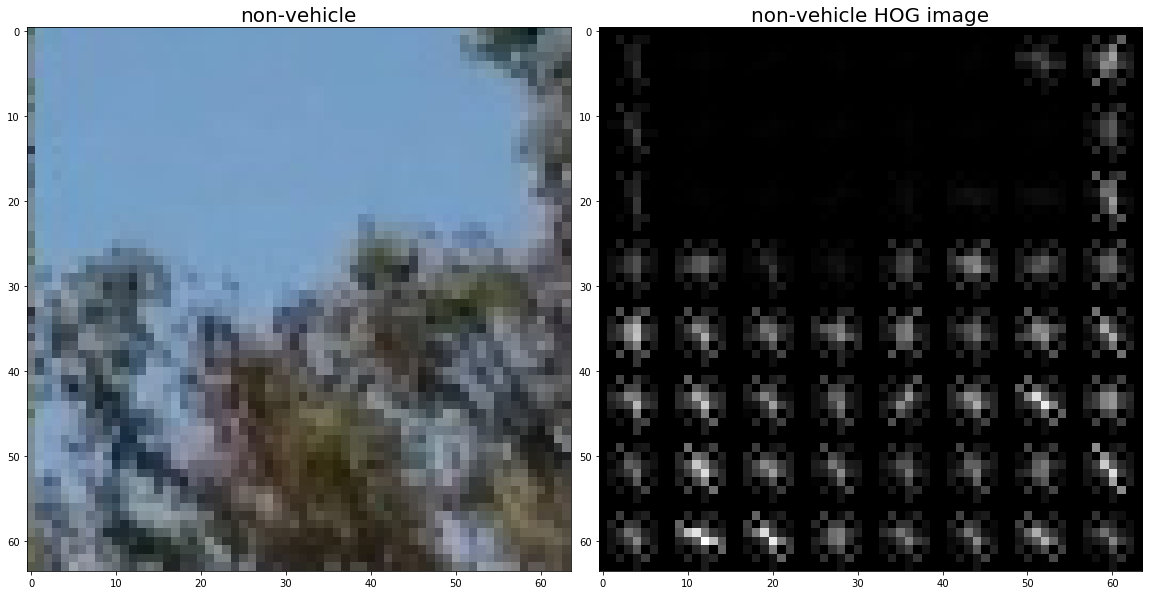

In [3]:
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

vehicleImagePath = '../Vehicle-Detection-Data/vehicles/KITTI_extracted/1.png'
vehicleImage = mpimg.imread(vehicleImagePath)
vehicleGrayImage = cv2.cvtColor(vehicleImage, cv2.COLOR_RGB2GRAY)

nonVehicleImagePath = '../Vehicle-Detection-Data/non-vehicles/Extras/extra2.png'
nonVehicleImage = mpimg.imread(nonVehicleImagePath)
nonVehicleGrayImage = cv2.cvtColor(nonVehicleImage, cv2.COLOR_RGB2GRAY)

visualizeResult2(vehicleImage, nonVehicleImage, 'vehicle', 'non-vehicle')
    
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell.
cell_per_block = 2 # HOG cells per block

vehicleFeatures, vehicleHogImage = get_hog_features(vehicleGrayImage, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
nonVehiclefeatures, nonVehicleHogImage = get_hog_features(nonVehicleGrayImage, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)

visualizeResult2(vehicleImage, vehicleHogImage, 'vehicle', 'vehicle HOG image', result_gray= True)

visualizeResult2(nonVehicleImage, nonVehicleHogImage, 'non-vehicle', 'non-vehicle HOG image', result_gray= True)

### Training vehicle detection system

In [4]:
import time
import pickle
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler


# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split



# train-step 1: Read in cars and notcars
images = glob.glob('../Vehicle-Detection-Data/**/*.png', recursive=True)
cars = []
notcars = []
for image in images:
    if 'non-vehicles' in image:
        notcars.append(image)
    else:
        cars.append(image)
print('len(notcars)=' + str(len(notcars)))
print('len(cars)=' + str(len(cars)))
print('Finished train-step 1: Read in cars and notcars')


# train-step 2: Extract Features
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel='ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64) 

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
print('Finished train-step 2: Extract Features')



# train-step 3: Standardize features by removing the mean and scaling to unit variance
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
print('Finished train-step 3: Standardize features by removing the mean and scaling to unit variance')



# train-step 4: Split arrays or matrices into random train and test subsets
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, stratify =y)
print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
print('Finished train-step 4: Split arrays or matrices into random train and test subsets')



# train-step 5: Linear Support Vector Classification
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
print('Finished train-step 5: Linear Support Vector Classification')



# train-step 6: Evaluating estimator performance
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
print('Finished train-step 6: Evaluating estimator performance')



# train-step 7: Save the trained settings
dist_pickle = {'svc': svc, 'X_scaler': X_scaler, 'orient': orient, 'pix_per_cell': pix_per_cell, 
               'cell_per_block': cell_per_block, 'spatial_size': spatial_size, 'hist_bins': hist_bins}
pickle.dump(dist_pickle, open("svc_pickle.p", "wb" ) )
print('Finished train-step 7: Save the trained settings')



print("Finished training vehicle detection system")

C:\Users\joern\Anaconda3\envs\CarND\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


len(notcars)=8968
len(cars)=8792
Finished train-step 1: Read in cars and notcars


C:\Users\joern\Anaconda3\envs\CarND\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Finished train-step 2: Extract Features
Finished train-step 3: Standardize features by removing the mean and scaling to unit variance
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
Finished train-step 4: Split arrays or matrices into random train and test subsets
4.93 Seconds to train SVC...
Finished train-step 5: Linear Support Vector Classification
Test Accuracy of SVC =  0.9901
Finished train-step 6: Evaluating estimator performance
Finished train-step 7: Save the trained settings
Finished training vehicle detection system


### Hog Sub-sampling Window Search

In [5]:
dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["X_scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]

In [6]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars_image(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, vis=False):
    box_list = []
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                box = ((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))
                
                box_list.append(box)
                cv2.rectangle(draw_img,box[0],box[1],(0,0,255),6) 
    if vis == True:
        return draw_img, box_list
    return box_list
    
ystart = 400
ystop = 656
scale = 1.5

### Multiple Detections & False Positives

In [7]:
from scipy.ndimage.measurements import label
from collections import deque

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [8]:
def pipelineImage(image):
    box_image, box_list = find_cars_image(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, 
                         spatial_size, hist_bins, vis=True)
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,box_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    result = draw_labeled_bboxes(np.copy(image), labels)
    return box_image, heatmap, result

In [9]:
def add_heatmap_and_threshold(image, heat_images, box_list, threshold):
        heatmap = np.zeros_like(image[:, :, 0]).astype(np.float)
        heatmap = add_heat(heatmap,box_list)

        heat_images.append(heatmap)
        heatmap = np.sum(np.array(heat_images), axis=0)
        heatmap = apply_threshold(heatmap, threshold)
        return heatmap

In [10]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars_video(img, frame_count, full_frame_processing_interval, xstart, ystart_ystop_scale, kernel):
    box_list = []
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    if frame_count % full_frame_processing_interval == 0:
        mask = np.ones_like(img[:, :, 0])
    else:
        mask = np.sum(np.array(heat_images), axis=0)
        mask[(mask > 0)] = 1
        mask = cv2.dilate(mask, kernel, iterations=1)

    frame_count += 1

    for (ystart, ystop, scale) in ystart_ystop_scale:
        nonzero = mask.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        if len(nonzeroy) != 0:
            ystart = max(np.min(nonzeroy), ystart)
            ystop = min(np.max(nonzeroy), ystop)
        if len(nonzeroy) != 0:
            xstart = max(np.min(nonzerox), xstart)
            xstop = np.max(nonzerox)
        else:
            continue

        if xstop <= xstart or ystop <= ystart:
            continue

        img_tosearch = img[ystart:ystop,:,:]
        ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
        if scale != 1:
            imshape = ctrans_tosearch.shape

            ys = np.int(imshape[1] / scale)
            xs = np.int(imshape[0] / scale)
            if (ys < 1 or xs < 1):
                continue

            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

        if ctrans_tosearch.shape[0] < 64 or ctrans_tosearch.shape[1] < 64:
                continue

        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]

        # Define blocks and steps as above
        ### change start
        nxblocks = (ch1.shape[1] // pix_per_cell)  - 1
        nyblocks = (ch1.shape[0] // pix_per_cell)  - 1 
        ### change end
        nfeat_per_block = orient*cell_per_block**2

        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // pix_per_cell) - 1

        cells_per_step = 2  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step

        # Compute individual channel HOG features for the entire image
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)


        for xb in range(nxsteps + 1):
            for yb in range(nysteps + 1):
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell

                # Extract the image patch
                subimg = ctrans_tosearch[ytop:ytop + window, xleft:xleft + window]  

                # Get color features
                spatial_features = bin_spatial(subimg, size=spatial_size)
                hist_features = color_hist(subimg, nbins=hist_bins)

                # Scale features and make a prediction
                test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
                #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
                test_prediction = svc.predict(test_features)

                if test_prediction == 1:
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    box = ((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))

                    box_list.append(box)
                

    return draw_img, box_list
    


In [11]:
# Current HeatMap
heatmap = None

# Heat Image for the Last five frames
heat_images = deque(maxlen=5)

# Current Frame Count
frame_count = 0
full_frame_processing_interval = 10

# Xstart
xstart = 600

# Various Scales
ystart_ystop_scale = [(350, 550, 1.5), (400, 600, 2.0), (450, 700, 2.5)]

# Kernal For Dilation
kernel = np.ones((50, 50))

# Threshold for Heatmap
threshold = 2

In [12]:
def pipelineVideo(image):
    draw_img, box_list = find_cars_video(image, frame_count, full_frame_processing_interval, xstart, ystart_ystop_scale, kernel)
    
    heatmap = add_heatmap_and_threshold(draw_img, heat_images, box_list, threshold)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(draw_img, labels)
    return draw_img

C:\Users\joern\Anaconda3\envs\CarND\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)
C:\Users\joern\Anaconda3\envs\CarND\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


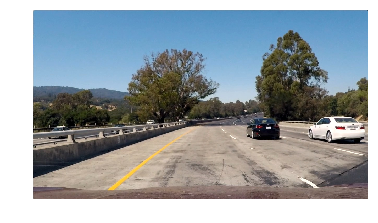

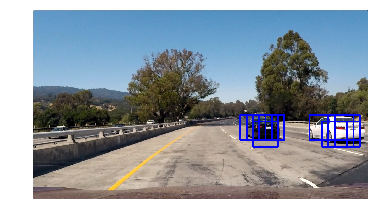

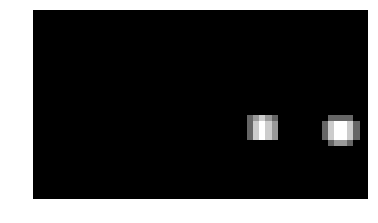

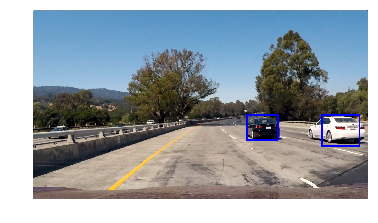

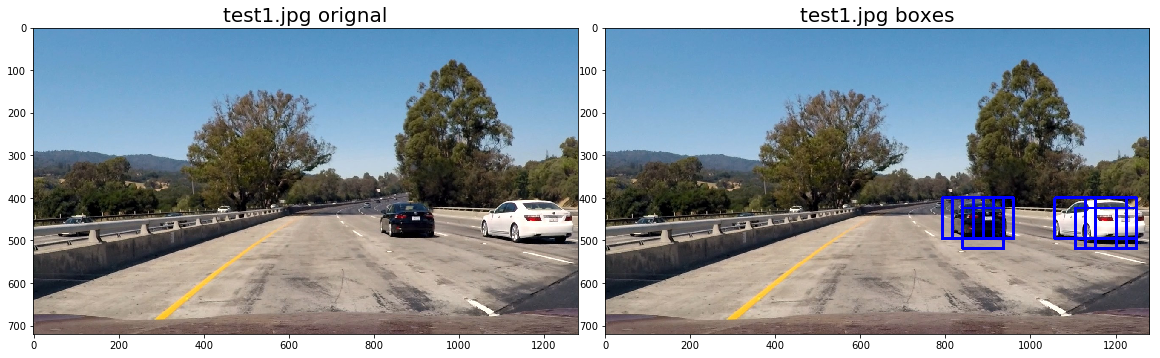

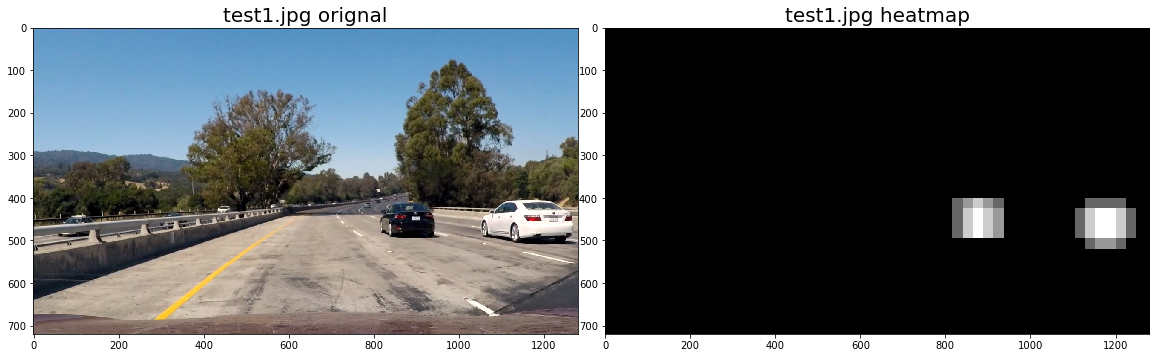

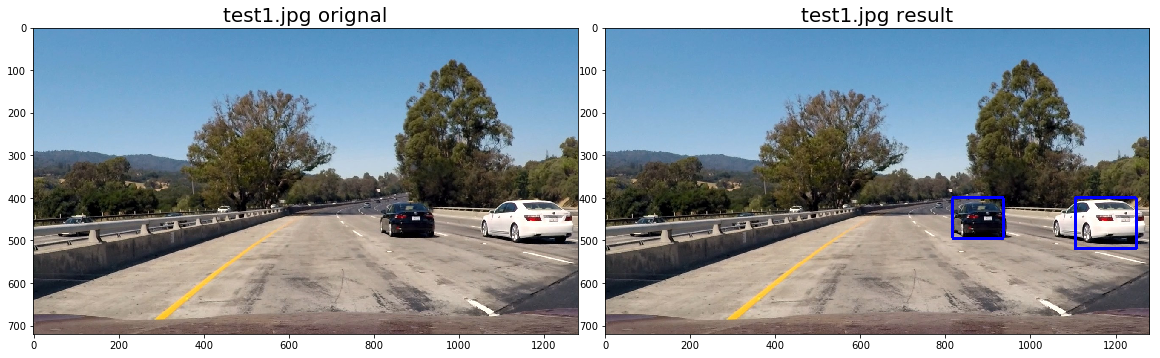

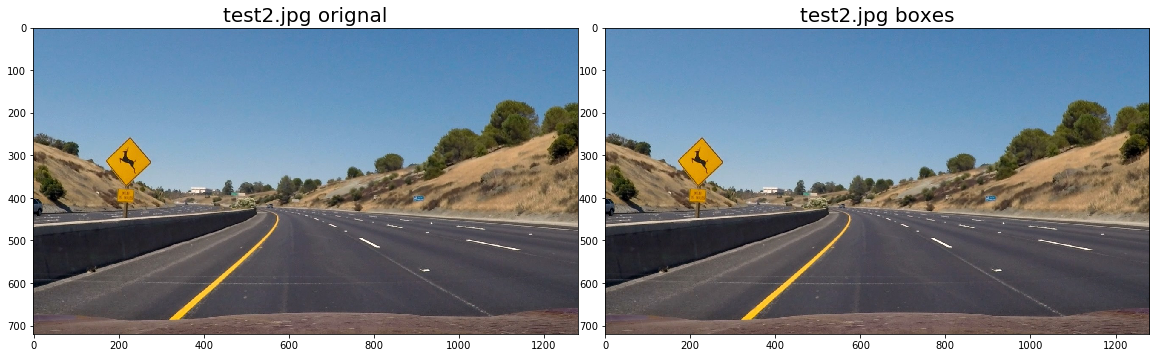

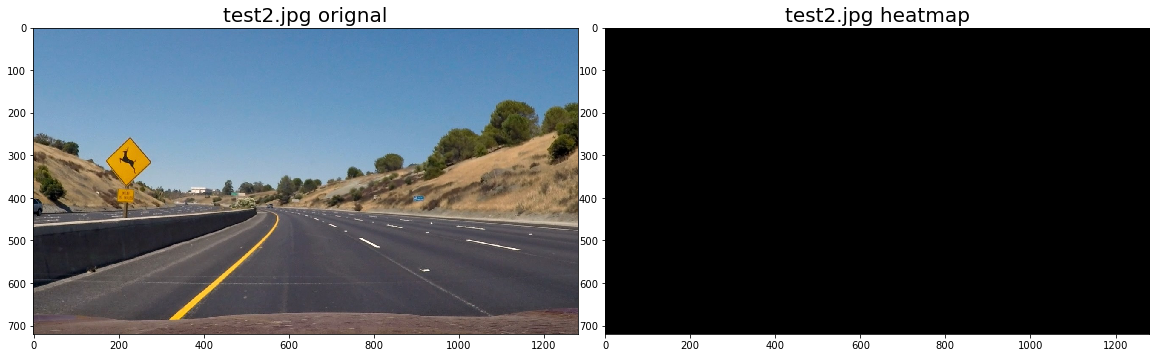

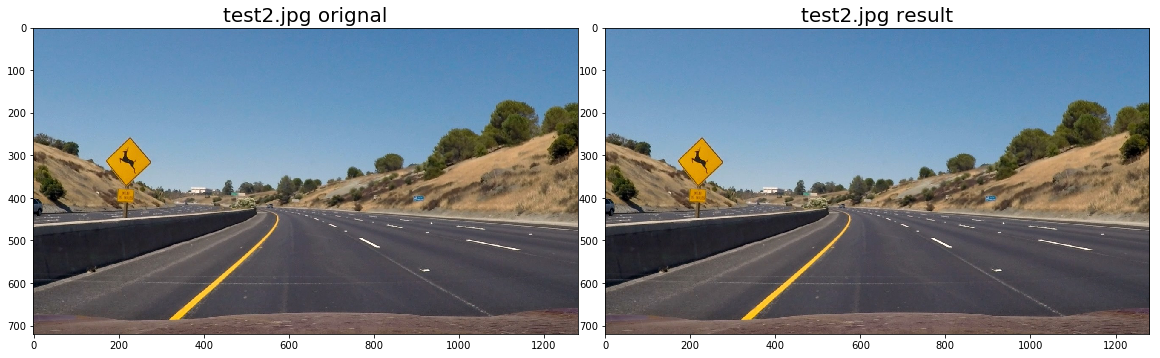

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


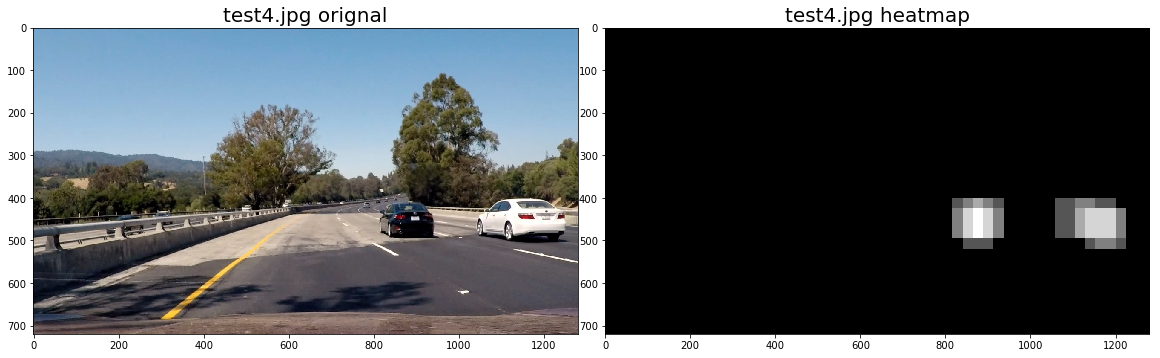

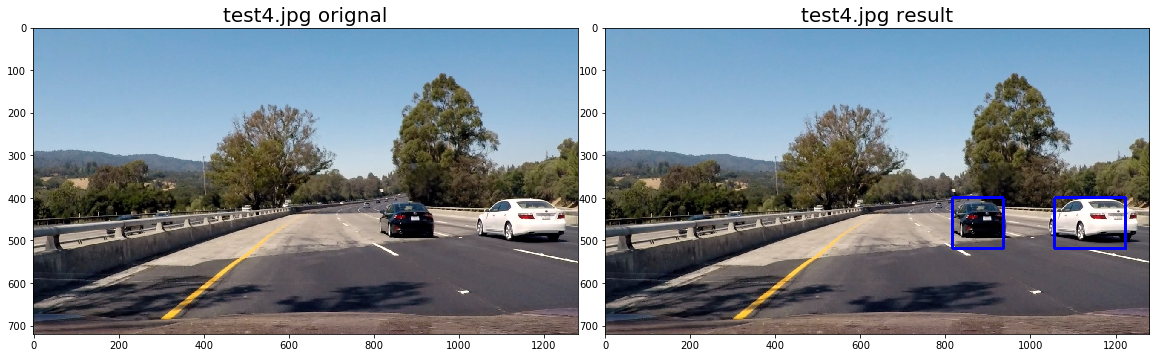

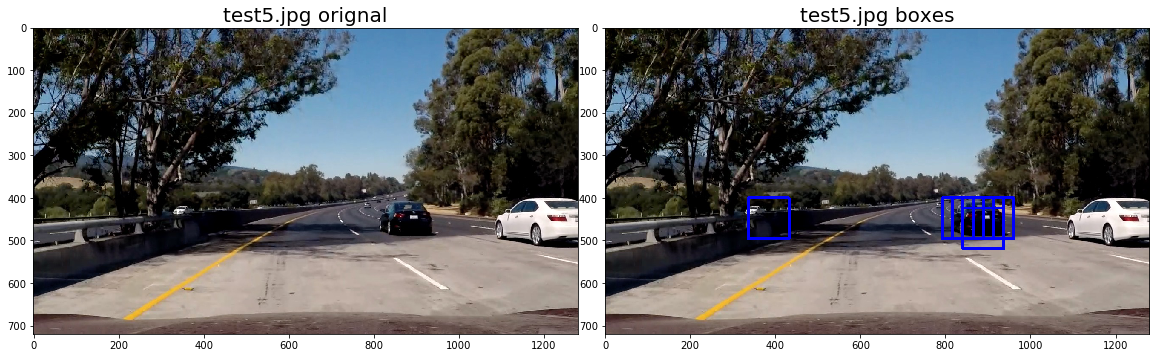

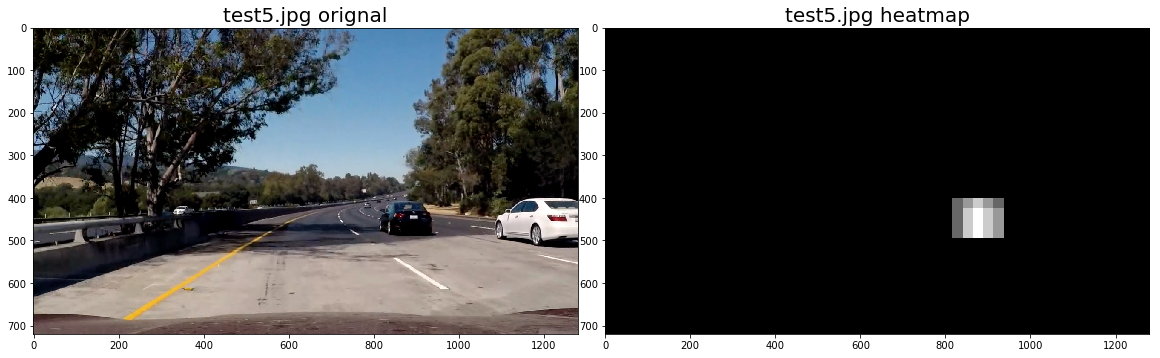

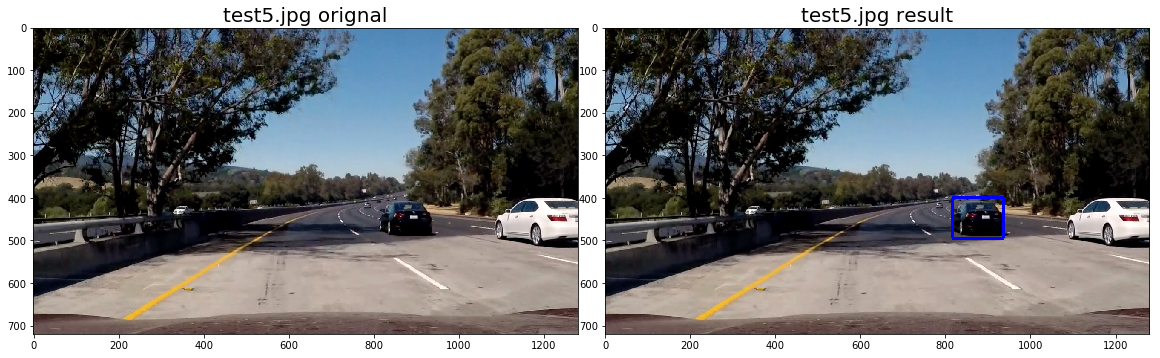

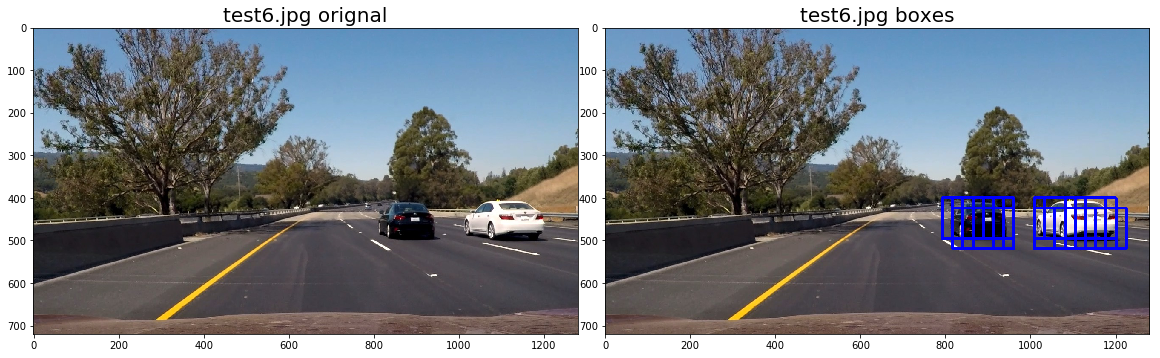

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [13]:
image1 = glob.glob('test_images/test1.jpg')

for imgPath in image1:
    image = mpimg.imread(imgPath)
    box_image, heatmap, result = pipelineImage(image)
    
    imageName = imgPath.split('/')[-1]
    output_path = 'output_images/'+ imageName
    
    plt.figure(1)
    plt.axis('off')
    fig1 = plt.imshow(image)
    plt.savefig(output_path + '_original.png')
    
    plt.figure(2)
    plt.axis('off')
    fig2 = plt.imshow(box_image)
    plt.savefig(output_path + '_boxes.png')
    
    plt.figure(3)
    plt.axis('off')
    fig3 =  plt.imshow(heatmap, cmap='gray')
    plt.savefig(output_path + '_heatmap.png')
    
    plt.figure(4)
    plt.axis('off')
    fig4 = plt.imshow(result)
    plt.savefig(output_path + '_result.png')
    
images = glob.glob('test_images/test*.jpg')

for imgPath in images:
    image = mpimg.imread(imgPath)
    box_image, heatmap, result = pipelineImage(image)
    
    imageName = imgPath.split('\\')[-1]
    output_path = 'output_images/'+ imageName
    
    visualizeResult2(image, box_image, imageName + ' orignal', imageName + ' boxes')
    visualizeResult2(image, heatmap, imageName + ' orignal', imageName + ' heatmap', result_gray= True)
    visualizeResult2(image, result, imageName +  ' orignal', imageName + ' result')

In [14]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

video_output = 'project_video_output.mp4'
clip = VideoFileClip("project_video.mp4")
white_clip = clip.fl_image(pipelineVideo)
%time white_clip.write_videofile(video_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [10:30<00:00,  2.02it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 10min 30s
